<a href="https://colab.research.google.com/github/AnabelBerumen/DataScientist/blob/main/Parkinson_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!mamba install -- upgrade scikit-learn=1.2.1
!mamba install seaborn --y

In [3]:
pip install skillsnetwork

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.4 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [2]:
!pip install dtreeviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 1.8 MB/s eta 0:00:00


In [4]:
import skillsnetwork
await skillsnetwork.download_dataset("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX01JCEN/data/parkinsons.data")


Saved as 'parkinsons.data'


In [5]:
from ast import increment_lineno
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Supress warnings generated by code
def warn(*args, **kwargs):
  pass

import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [6]:
# Creatin helper function for ploting
sns.set(style='whitegrid', color_codes=True)
import itertools

def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting 'normalize=True'.
  """
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
  else:
    print('Confusion matrix, without normalization')

  print(cm)

  thresh = 3 * cm.max()/4
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [7]:
data = pd.read_csv('parkinsons.data', sep=',', index_col='name')
data.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
name,,,,,,,,,,,,,,,,,,,,,
phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [8]:
data.shape

(195, 23)

<Axes: >

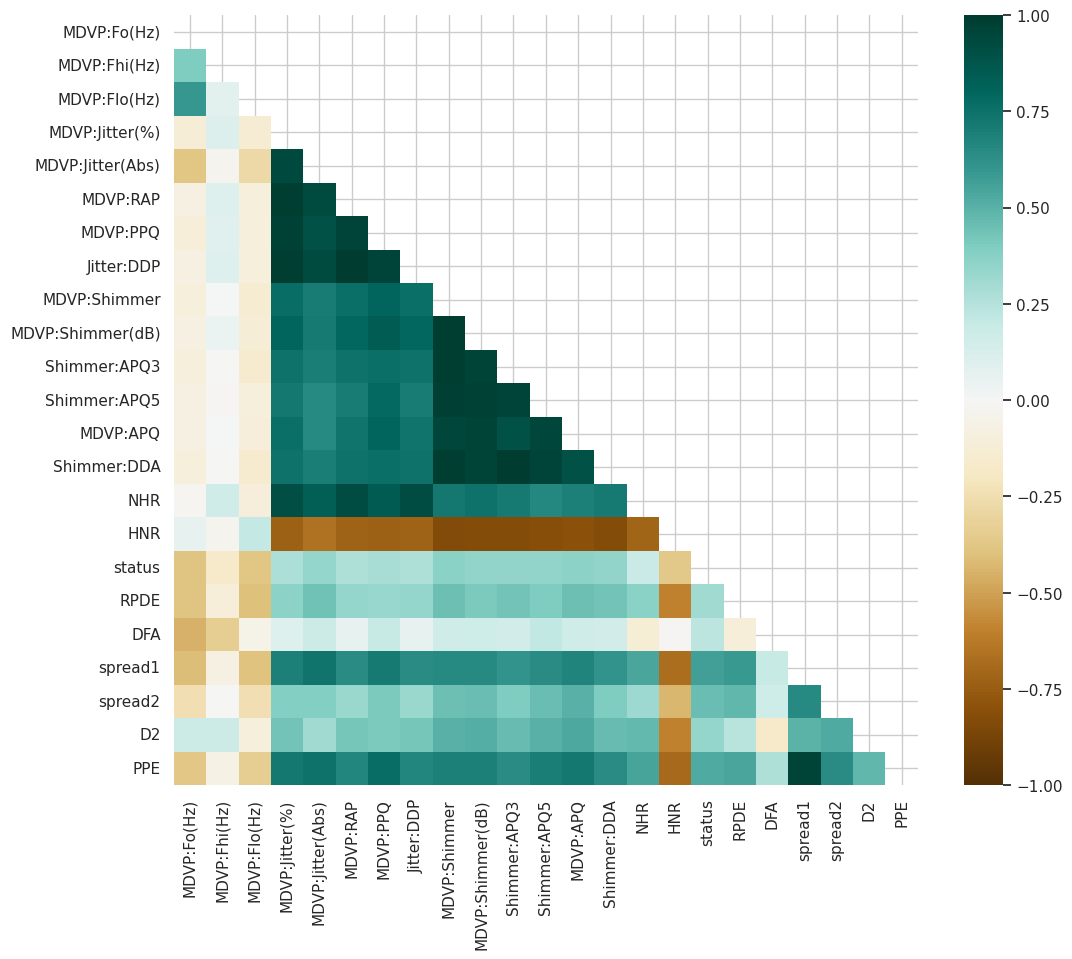

In [9]:
# creating the correlation matrix
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(data.corr(), dtype=bool))
sns.heatmap(data.corr(), vmin=-1, vmax=1, cmap='BrBG', mask=mask)

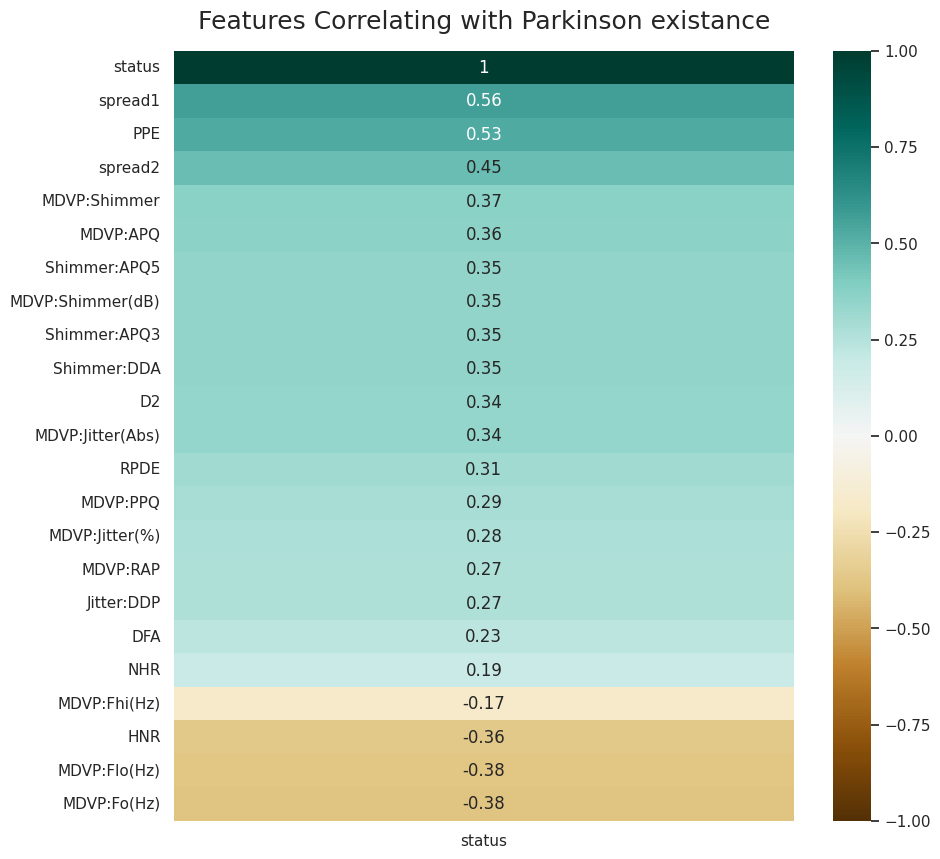

In [10]:
# modify the headmap plot to show correlation variables to the statues
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(data.corr()[['status']].sort_values(by='status', ascending=False), vmin=-1,
                      vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Parkinson existance', fontdict={'fontsize':18}, pad=16);

In [11]:
X = data.drop('status', axis=1)
X.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
name,,,,,,,,,,,,,,,,,,,,,
phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.03590,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.04465,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [12]:
y=data['status']
y.head()

name
phon_R01_S01_1    1
phon_R01_S01_2    1
phon_R01_S01_3    1
phon_R01_S01_4    1
phon_R01_S01_5    1
Name: status, dtype: int64

In [14]:
y.value_counts(normalize=True)

status
1    0.753846
0    0.246154
Name: proportion, dtype: float64

**3/4 of the samples are have Parkinson's)**

**t-Distributed Stochastic Neighbor Embedding**

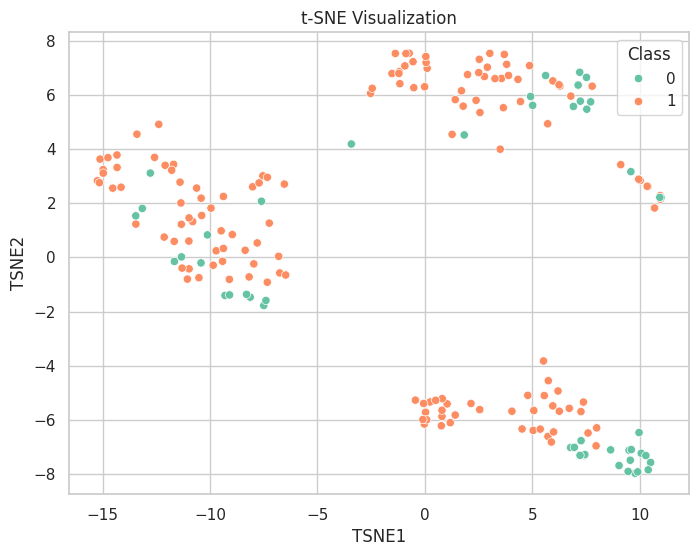

In [16]:
import seaborn as sns
from sklearn.manifold import TSNE

# Appy t-SNE to reduce the dimentions to 2
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Create a DataFrame with the t-SNE-transformed data and class labels
tsne_df = pd.DataFrame(data=X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['Class'] = y.values

# Visualize the data based on class using a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Class', palette='Set2')
plt.title('t-SNE Visualization')
plt.show()

In [17]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)


# print the shape of train and test data
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (136, 22)
y_train shape:  (136,)
X_test shape:  (59, 22)
y_test shape:  (59,)


## K-NN

In [19]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_pred[:10]

array([1, 0, 1, 1, 1, 1, 1, 0, 0, 0])

In [20]:
knn.predict_proba(X_test)[:10]

array([[0.33333333, 0.66666667],
       [0.66666667, 0.33333333],
       [0.33333333, 0.66666667],
       [0.33333333, 0.66666667],
       [0.        , 1.        ],
       [0.33333333, 0.66666667],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ]])

Confusion matrix, without normalization
[[ 9  3]
 [ 5 42]]


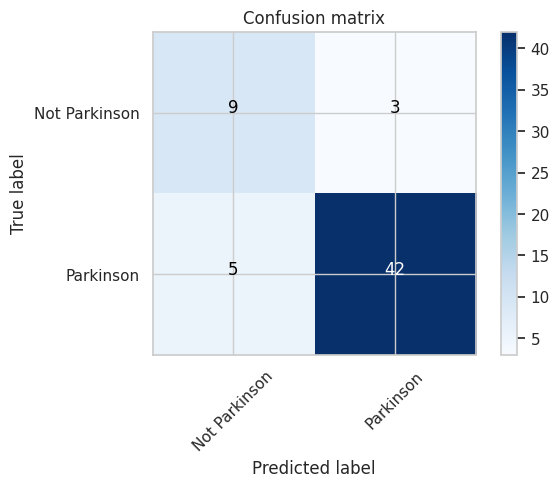

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

plot_confusion_matrix(confusion_matrix(y_test, y_pred),
                      classes=['Not Parkinson', 'Parkinson'], title='Confusion matrix')

In [22]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.75      0.69        12
           1       0.93      0.89      0.91        47

    accuracy                           0.86        59
   macro avg       0.79      0.82      0.80        59
weighted avg       0.87      0.86      0.87        59


Accuracy Score: 0.864406779661017


## GridSearchCV

In [24]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, scoring='recall', cv=5)
grid_search

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9]}, scoring='recall')

In [27]:
grid_search.fit(X_train, y_train)
print('Best parameters: ', grid_search.best_params_)
print('Best Score: ', grid_search.best_score_)

Best parameters:  {'n_neighbors': 9}
Best Score:  0.97


In [30]:
from sklearn.metrics import recall_score

y_pred = grid_search.best_estimator_.predict(X_test)

recall = recall_score(y_test, y_pred)
recall

0.9148936170212766

In [31]:
y_hat = grid_search.best_estimator_.predict(X)
knn = KNeighborsClassifier()
knn.fit(X, y)

KNeighborsClassifier()

Confusion matrix, without normalization
[[ 32  16]
 [  5 142]]


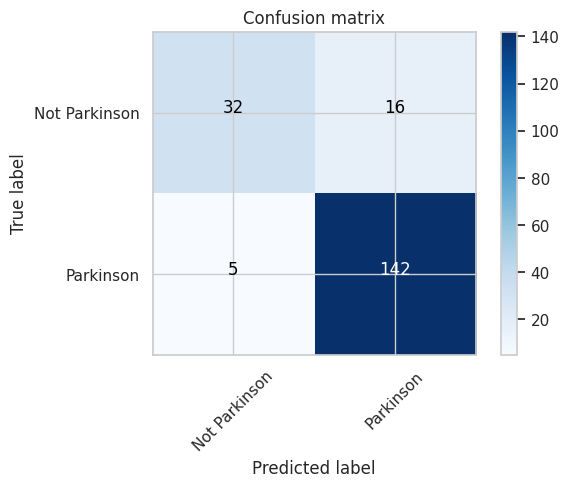

In [32]:
y_hat = knn.predict(X)

plot_confusion_matrix(confusion_matrix(y, y_hat),
                      classes=['Not Parkinson', 'Parkinson'], title='Confusion matrix')

In [33]:
# find true positives(tp)
tsne_df['label']=''
tsne_df['label'].iloc[np.where((y_hat == 1) & (y == 1))]="TP"
# find true negatives (tn)
tsne_df['label'].iloc[np.where((y_hat == 0) & (y == 0))]="TN"
# find false positives (fp)
tsne_df['label'].iloc[np.where((y_hat == 1) & (y == 0))]="FP"
# find false negatives (fp)
tsne_df['label'].iloc[np.where((y_hat == 0) & (y == 1))]="FN"

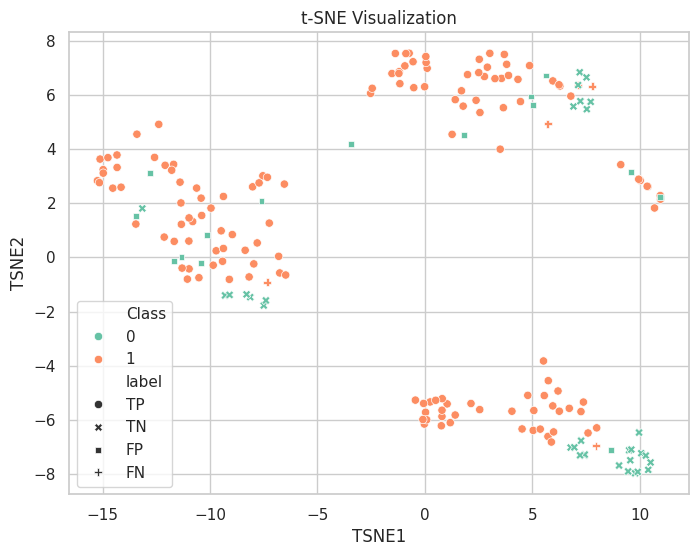

In [34]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Class', palette='Set2',style='label')
plt.title('t-SNE Visualization')
plt.show()

<ul>
  <li><a href="https://github.com/slundberg/shap">SHAP</a></li>
  <li><a href="https://github.com/marcotcr/lime">LIME</a></li>
  <li><a href="https://github.com/oracle/Skater">Skater</a></li>
  <li><a href="https://github.com/microsoft/interpret">Microsoft InterpretML</a></li>
  <li><a href="https://github.com/interpretml/interpret-text">Interpret-text</a></li>
  <li><a href="https://github.com/interpretml/interpret-core">Interpret-core</a></li>
  <li><a href="https://github.com/surrey-unplugged/saliency">Saliency</a></li>
  <li><a href="https://github.com/PAIR-code/facets">Facets</a></li>
  <li><a href="https://github.com/marcotcr/photonai">Photonai</a></li>
</ul>

## Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred[:10]

array([1, 0, 1, 1, 1, 1, 1, 0, 0, 0])

In [36]:
lr.predict_proba(X_test)[:10]

array([[0.26796849, 0.73203151],
       [0.69161219, 0.30838781],
       [0.06764952, 0.93235048],
       [0.38588988, 0.61411012],
       [0.07237225, 0.92762775],
       [0.26252443, 0.73747557],
       [0.00912184, 0.99087816],
       [0.5108703 , 0.4891297 ],
       [0.85915321, 0.14084679],
       [0.90263876, 0.09736124]])

Confusion matrix, without normalization
[[ 9  3]
 [ 6 41]]

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.75      0.67        12
           1       0.93      0.87      0.90        47

    accuracy                           0.85        59
   macro avg       0.77      0.81      0.78        59
weighted avg       0.86      0.85      0.85        59


Accuracy Score:
 0.847457627118644


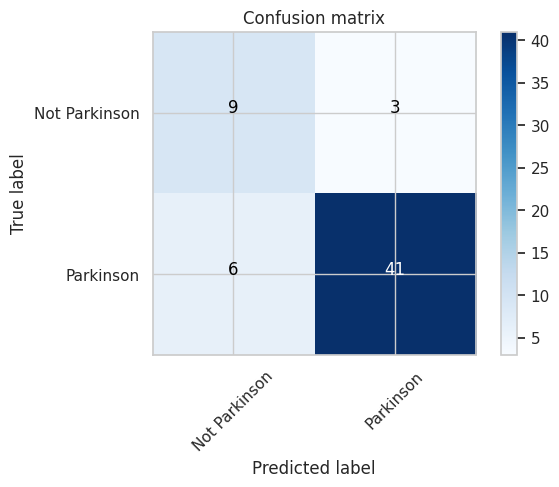

In [37]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred),
                      classes = ['Not Parkinson', 'Parkinson'],
                      title='Confusion matrix')
print('\nClassification Report:\n', classification_report(y_test, y_pred))
print('\nAccuracy Score:\n', accuracy_score(y_test, y_pred))

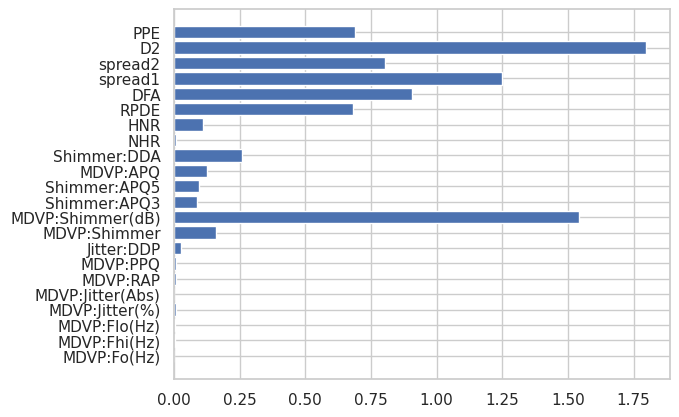

In [38]:
coef = abs(lr.coef_[0])
plt.barh(X.columns, coef)
plt.show()

**Select the features with the highest magnitude coefficients**

In [39]:
best_columns = X.columns[np.argsort(-1*coef)[:5]]
best_columns

Index(['D2', 'MDVP:Shimmer(dB)', 'spread1', 'DFA', 'spread2'], dtype='object')

Confusion matrix, without normalization
[[ 9  3]
 [ 6 41]]

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.75      0.67        12
           1       0.93      0.87      0.90        47

    accuracy                           0.85        59
   macro avg       0.77      0.81      0.78        59
weighted avg       0.86      0.85      0.85        59


Accuracy Score: 0.847457627118644


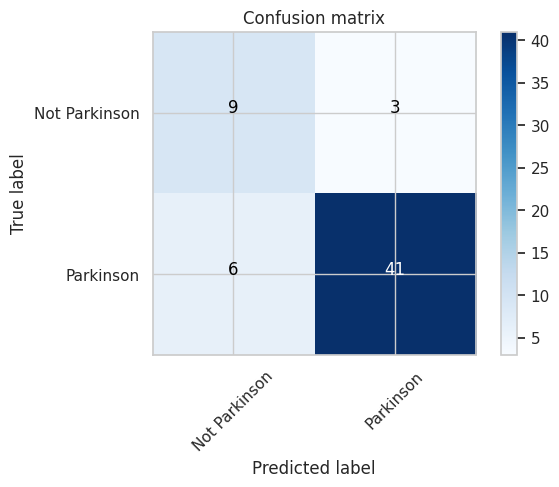

In [42]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train[best_columns], y_train)

y_pred_proba = log_reg.predict_proba(X_test[best_columns])

plot_confusion_matrix(confusion_matrix(y_test, y_pred),
                      classes=['Not Parkinson', 'Parkinson'],
                      title='Confusion matrix')
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

## SVM

Confusion matrix, without normalization
[[ 4  8]
 [ 2 45]]


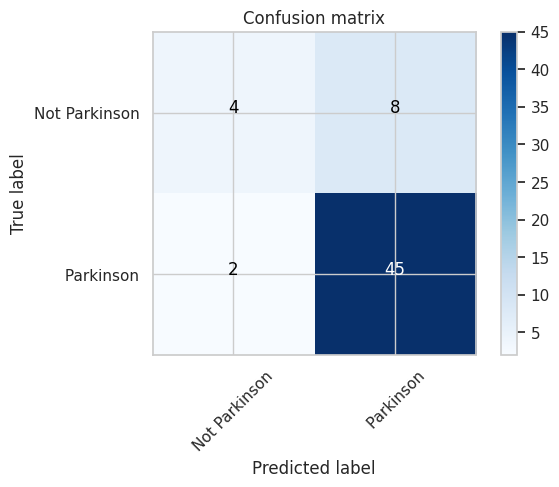

In [46]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)

y_hat = svm.predict(X_test)

# confusion_matrix
plot_confusion_matrix(confusion_matrix(y_test, y_hat),classes=[ "Not Parkinson", " Parkinson"],title='Confusion matrix')

In [47]:
param_grid = {
    'C': [0.1, 1,],
    'gamma': [0.1, 1, 10],

}
svm = SVC()

grid_search = GridSearchCV(svm, param_grid, scoring='recall', cv=5)

grid_search.fit(X_train, y_train)
print("Best hyperparameters: ", grid_search.best_params_)
print("Best recall score: ", grid_search.best_score_)

Best hyperparameters:  {'C': 0.1, 'gamma': 0.1}
Best recall score:  1.0


## Random Forest Classifier

In [49]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=123)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 89.83%


In [51]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5,10,15],
    'max_features': ['sqrt', 'log2'],

}
rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf, param_grid, cv=5)

grid_search.fit(X_train, y_train)
print("Best hyperparameters: ", grid_search.best_params_)
print("Best recall Model: ", grid_search.best_estimator_)

Best hyperparameters:  {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}
Best recall Model:  RandomForestClassifier(max_depth=5, random_state=42)


<Axes: >

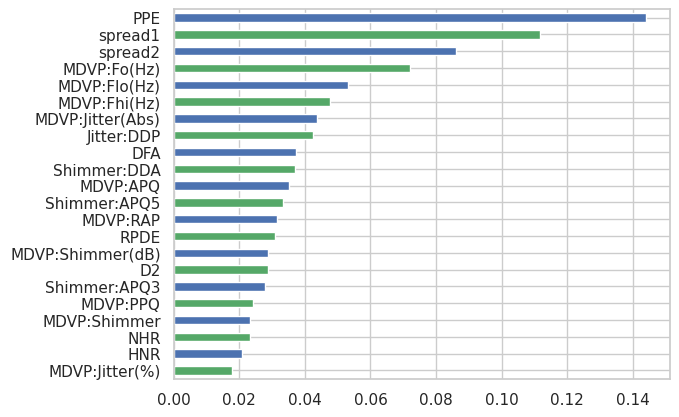

In [54]:
# plot the important features
rf.fit(X_train, y_train)
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh', color=['g', 'b'])

In [55]:
# Save the trained model
import pickle

filename = 'rf_model_parkinson'
pickle.dump(rf, open(filename, 'wb'))

In [56]:
# Viksualizate the Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Parameter grid
param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth': [2, 4],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

dt = DecisionTreeClassifier()

grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best recall score:", grid_search.best_score_)

Best parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best recall score: 0.8743386243386244


In [60]:
clf = DecisionTreeClassifier(criterion ='gini', max_depth=4, min_samples_leaf=2,
                            min_samples_split=2)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

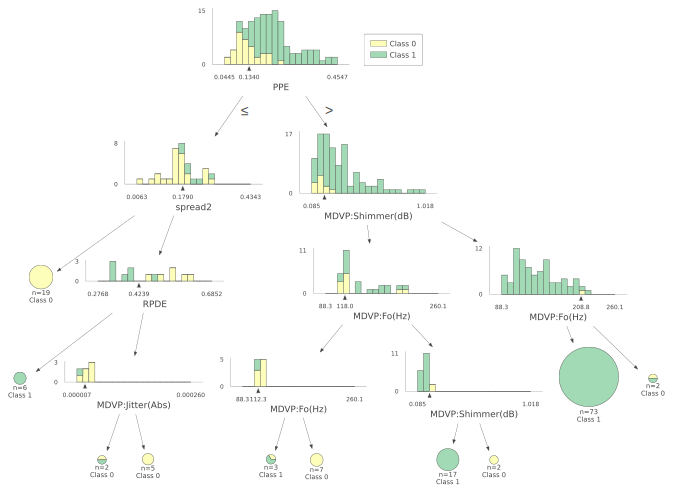

In [61]:
import dtreeviz

feature_names = list(X_train.columns)

viz_model = dtreeviz.model(clf,
                           X_train=X_train, y_train=y_train,
                           feature_names=feature_names)

v = viz_model.view(fancy=True)
v

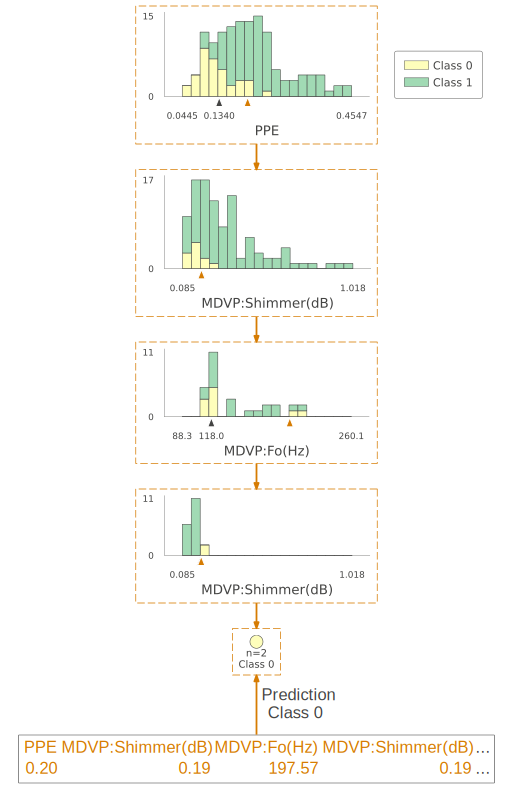

In [63]:
# Lets choose a random point and visualize the decision path

rand = np.random.randint(0, len(X))
sample_point = X.iloc[rand, :].values

v = viz_model.view(fancy=True, scale=1.5, x=sample_point, show_just_path=True)
v